In [47]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:
https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

In [67]:
apps = pd.read_csv('data/googleplaystore.csv')
apps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [49]:
df = pd.read_csv('data/googleplaystore_user_reviews.csv')
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [50]:
#clean column headers
apps.columns = apps.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
apps.head()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [51]:
#clean column headers
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [52]:
apps.isna().sum()

app                  0
category             0
rating            1474
reviews              0
size                 0
installs             0
type                 1
price                0
content_rating       1
genres               0
last_updated         0
current_ver          8
android_ver          3
dtype: int64

In [53]:
df.isna().sum()

app                           0
translated_review         26868
sentiment                 26863
sentiment_polarity        26863
sentiment_subjectivity    26863
dtype: int64

In [37]:
df.translated_review.dtype

dtype('O')

In [54]:
df = pd.merge(df, apps, how='right', on='app')

df.head(10)

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
2,10 Best Foods for You,NaN,NaN,NaN,NaN,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
6,10 Best Foods for You,Amazing,Positive,0.60,0.900000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
7,10 Best Foods for You,NaN,NaN,NaN,NaN,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
8,10 Best Foods for You,"Looking forward app,",Neutral,0.00,0.000000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up
9,10 Best Foods for You,It helpful site ! It help foods get !,Neutral,0.00,0.000000,HEALTH_AND_FITNESS,4.0,2490,3.8M,"500,000+",Free,0,Everyone 10+,Health & Fitness,"February 17, 2017",1.9,2.3.3 and up


In [55]:
df_dating = df[df['category'] == 'DATING']
df_dating.head()

,app,translated_review,sentiment,sentiment_polarity,sentiment_subjectivity,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
840,"2Date Dating App, Love and matching","This good dating app, I love much. This lot Ch...",Positive,0.250980,0.532773,DATING,4.4,41605,8.1M,"500,000+",Free,0,Mature 17+,Dating,"July 26, 2018",4.813,4.0.3 and up
841,"2Date Dating App, Love and matching",Thank friend introduced dating me. This change...,Positive,0.369697,0.584848,DATING,4.4,41605,8.1M,"500,000+",Free,0,Mature 17+,Dating,"July 26, 2018",4.813,4.0.3 and up
842,"2Date Dating App, Love and matching","This seems nice, need VIP even send message an...",Positive,0.450000,0.652778,DATING,4.4,41605,8.1M,"500,000+",Free,0,Mature 17+,Dating,"July 26, 2018",4.813,4.0.3 and up
843,"2Date Dating App, Love and matching",Dont waste money become VIP. Tons there. This ...,Negative,-0.200000,0.000000,DATING,4.4,41605,8.1M,"500,000+",Free,0,Mature 17+,Dating,"July 26, 2018",4.813,4.0.3 and up
844,"2Date Dating App, Love and matching",Fu....ng app. Just wasting time. You send rece...,Positive,0.500000,0.500000,DATING,4.4,41605,8.1M,"500,000+",Free,0,Mature 17+,Dating,"July 26, 2018",4.813,4.0.3 and up


In [57]:
df_dating['translated_review'] = df['translated_review'].apply(lambda x: str(x))

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_dating.translated_review.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[['this', 'good', 'dating', 'app', 'love', 'much', 'this', 'lot', 'chinese', 'english', 'speaking', 'members', 'most', 'active', 'chat', 'requests', 'soon', 'registered', 'there', 'advertising', 'chat', 'others', 'members', 'freely', 'used', 'different', 'dating', 'apps', 'functions', 'simple', 'direct', 'one', 'users', 'exchanged', 'contact', 'easily', 'those', 'guys', 'met', 'nice', 'gentle', 'serious', 'feeling', 'good', 'it', 'hopefully', 'every', 'enjoy', 'using', 'app']]


In [39]:
conda install -c conda-forge spacy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [40]:
conda install -c conda-forge spacy-model-en_core_web_md

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [58]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp=spacy.load('en_core_web_sm')
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [59]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

//anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


[(0,
  '0.047*"profile" + 0.046*"work" + 0.034*"app" + 0.027*"never" + 0.026*"well" '
  '+ 0.026*"really" + 0.023*"free" + 0.023*"delete" + 0.020*"find" + '
  '0.017*"great"'),
 (1,
  '0.045*"time" + 0.041*"date" + 0.019*"phone" + 0.019*"sure" + 0.018*"bad" + '
  '0.018*"problem" + 0.015*"issue" + 0.014*"love" + 0.013*"fun" + '
  '0.013*"sign"'),
 (2,
  '0.055*"like" + 0.045*"pay" + 0.035*"message" + 0.021*"fake" + '
  '0.020*"update" + 0.019*"let" + 0.019*"reply" + 0.017*"remove" + '
  '0.015*"back" + 0.014*"feel"'),
 (3,
  '0.118*"people" + 0.033*"look" + 0.032*"conversation" + 0.029*"away" + '
  '0.023*"far" + 0.018*"day" + 0.017*"still" + 0.016*"start" + '
  '0.016*"actually" + 0.016*"way"')]


In [60]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5013,"profile, work, app, never, well, really, free,...","[date, love, much, chinese, speak, member, act..."
1,1,1.0,0.5040,"time, date, phone, sure, bad, problem, issue, ...","[friend, introduce, date, change, impression, ..."
2,2,2.0,0.4942,"like, pay, message, fake, update, let, reply, ...","[vip, send, message, party, issue, user, wish,..."
3,3,2.0,0.3604,"like, pay, message, fake, update, let, reply, ...","[waste, money, become, vip, ton, scam, rubbish]"
4,4,2.0,0.5840,"like, pay, message, fake, update, let, reply, ...","[waste, time, send, receive, heart, sign, send..."
5,5,0.0,0.7448,"profile, work, app, never, well, really, free,...","[date, much, different, dating, app, member, t..."
6,6,0.0,0.4667,"profile, work, app, never, well, really, free,...","[happy, interesting, friend, glad, meet, let, ..."
7,7,3.0,0.3306,"people, look, conversation, away, far, day, st...","[actually, thing, allow, match, day, filter, c..."
8,8,0.0,0.7576,"profile, work, app, never, well, really, free,...","[gal, user, friendly, date, app, much, well]"
9,9,0.0,0.9086,"profile, work, app, never, well, really, free,...","[attractive, function, member, friendly, choic..."


In [61]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9504,"profile, work, app, never, well, really, free, delete, find, great","[really, great, find, girlfriend, life, much, well, pretty, cute, fit, requirement, imagine, lif..."
1,1.0,0.9640,"time, date, phone, sure, bad, problem, issue, love, fun, sign","[time, pass, verify, capcha, screen, keep, reapeere, making, already, give, trash, phone, keep, ..."
2,2.0,0.9385,"like, pay, message, fake, update, let, reply, remove, back, feel","[fix, bug, first, message, send, bug, message, send, fix, greatly, appreciate, ferzu]"
3,3.0,0.9247,"people, look, conversation, away, far, day, still, start, actually, way","[typical, tinder, blonde, people, character, personality, present, sapiosexual, people]"


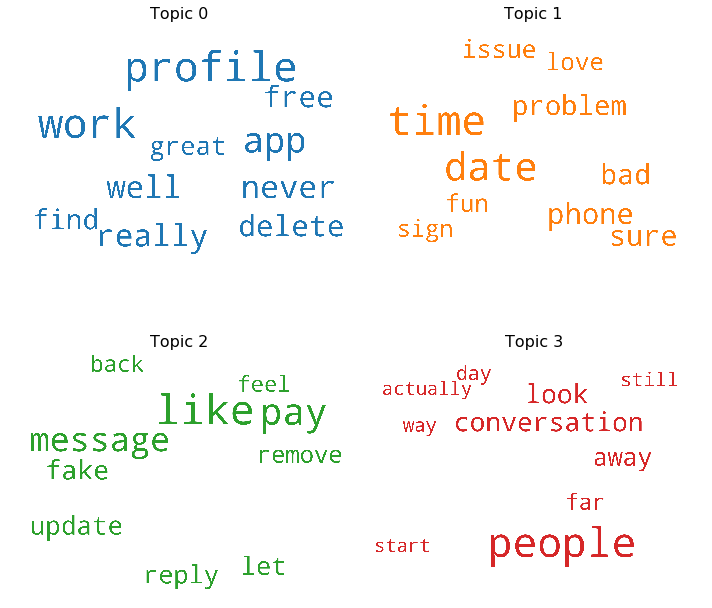

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

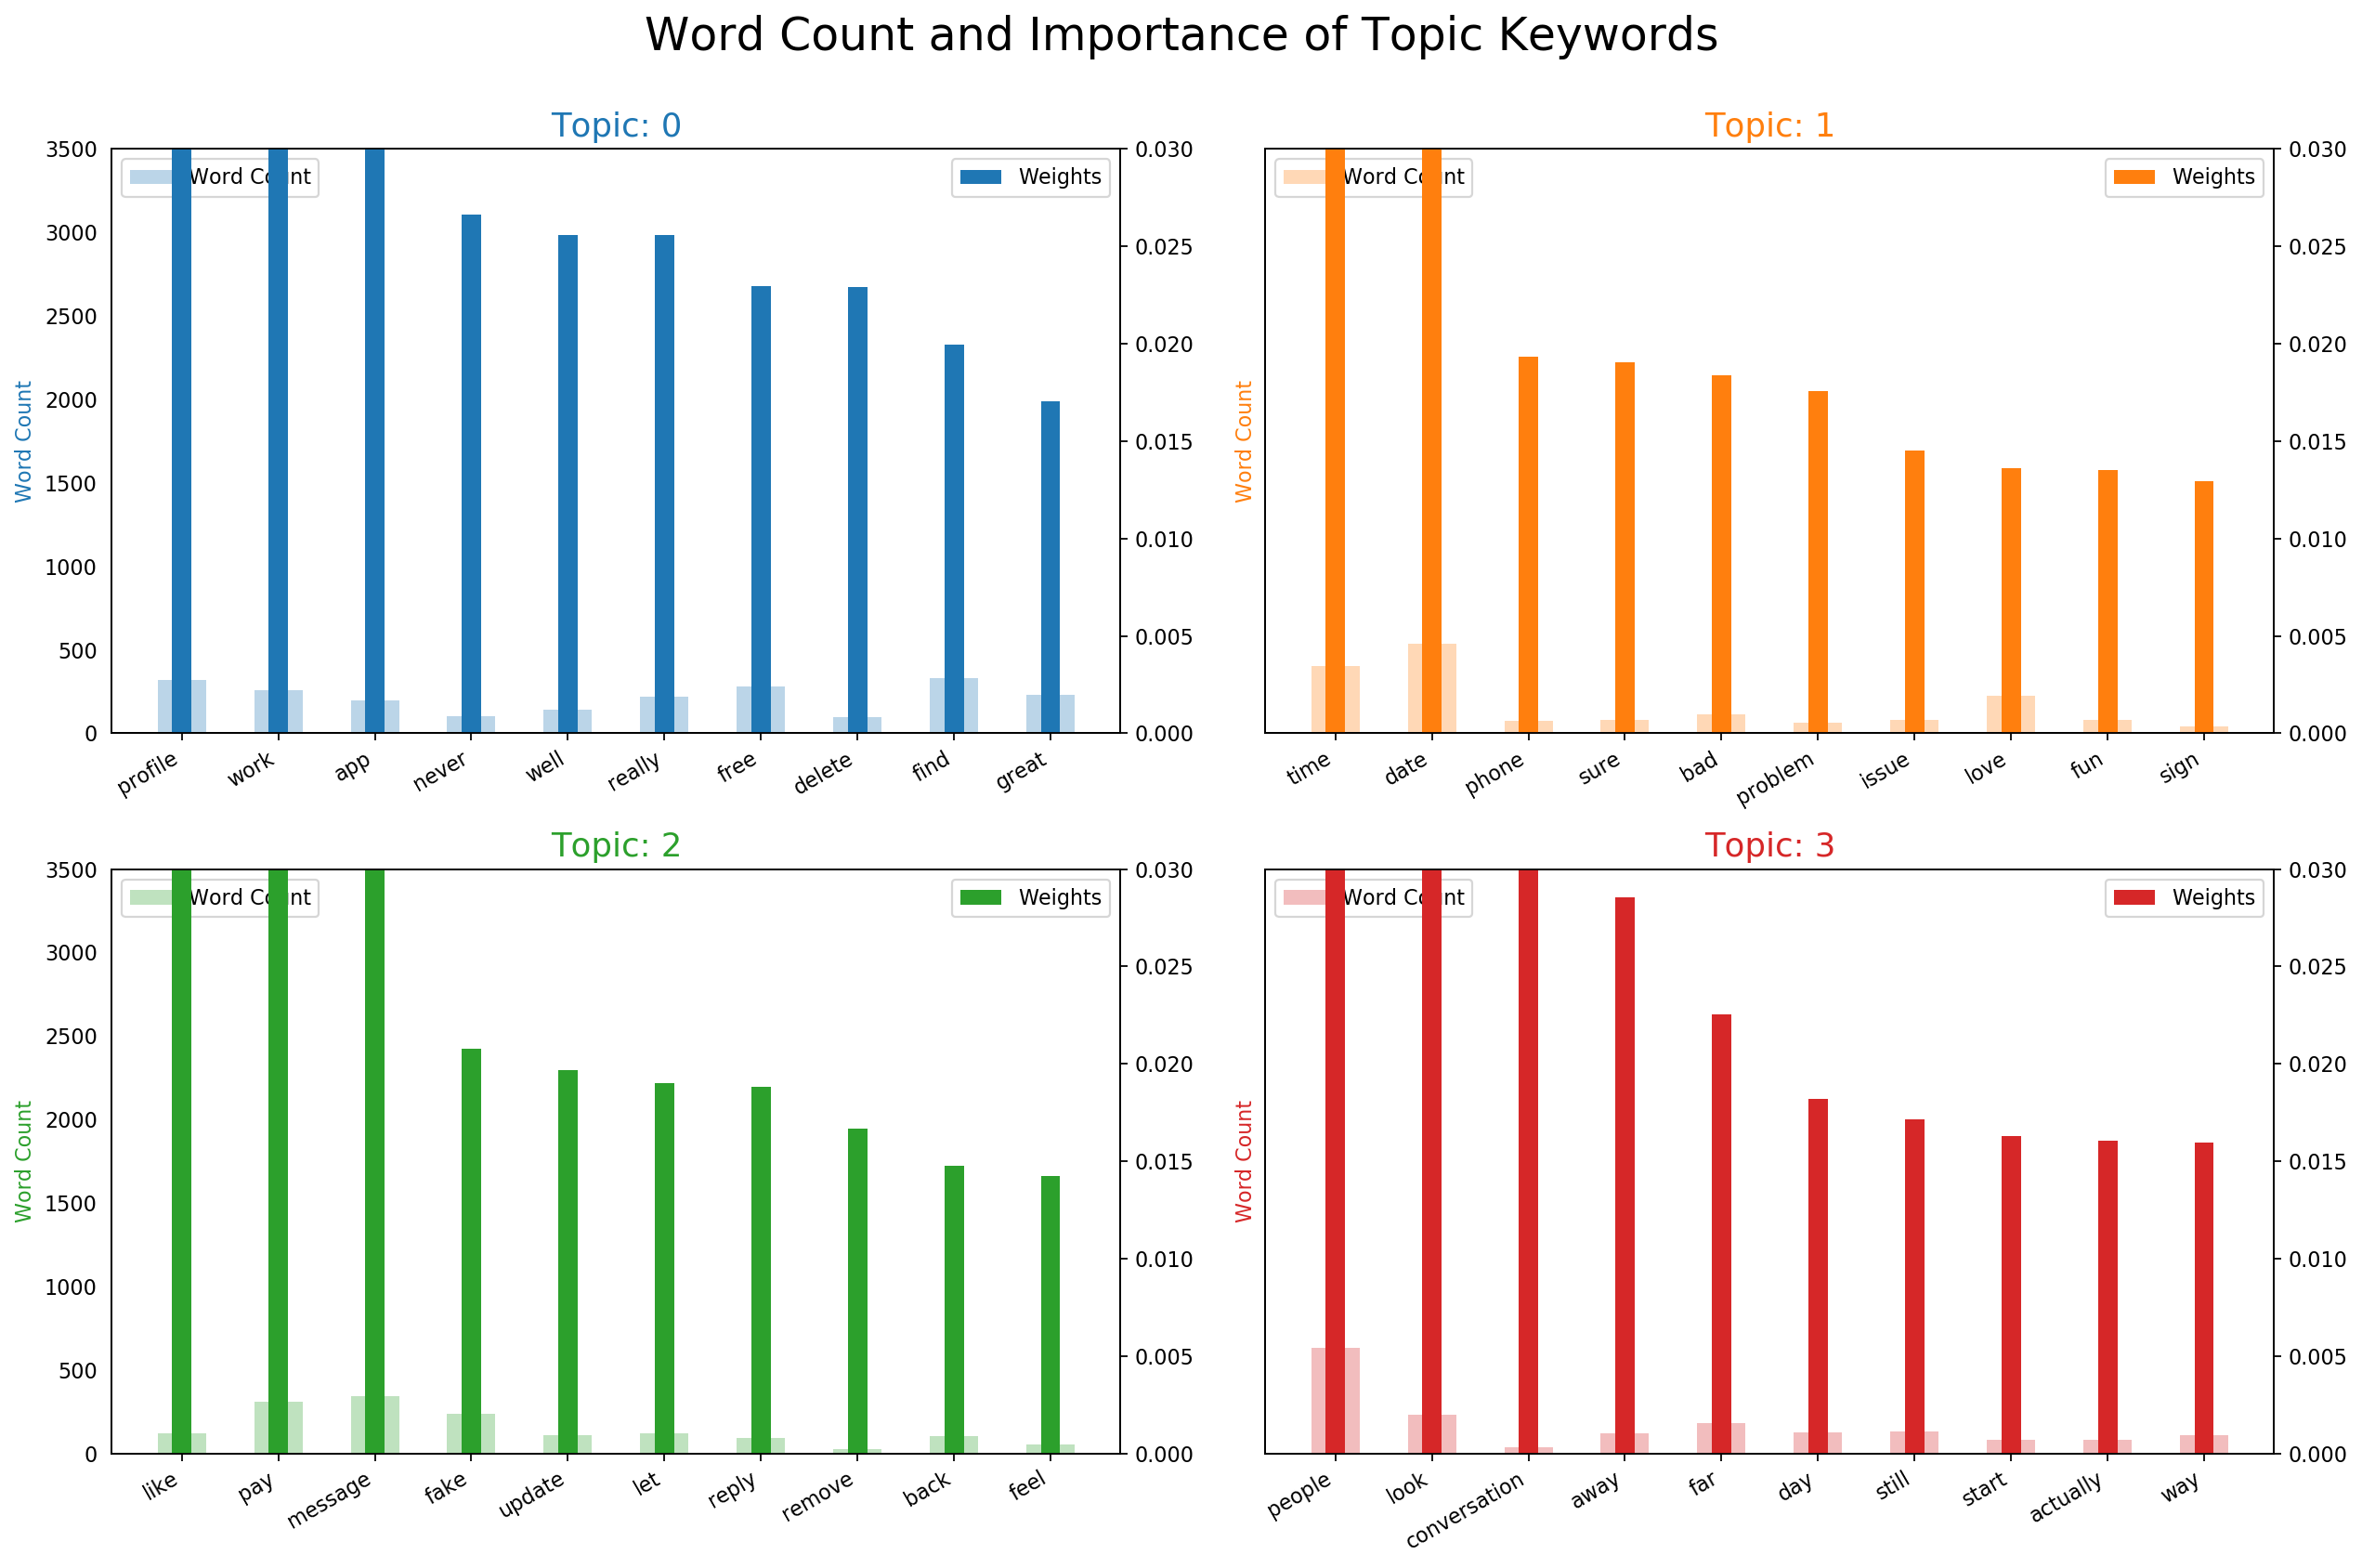

In [63]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [64]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2698 samples in 0.001s...
[t-SNE] Computed neighbors for 2698 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2698
[t-SNE] Computed conditional probabilities for sample 2000 / 2698
[t-SNE] Computed conditional probabilities for sample 2698 / 2698
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.390377
[t-SNE] KL divergence after 1000 iterations: 0.313024


Loading BokehJS ...

In [66]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

//anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.244501  0.112303       1        1  31.700548
2      0.195987  0.183148       2        1  24.995859
1      0.005721 -0.113473       3        1  24.517756
3      0.042793 -0.181978       4        1  18.785835, topic_info=    Category        Freq     Term       Total  loglift  logprob
133  Default  604.000000   people  604.000000  30.0000  30.0000
126  Default  378.000000     like  378.000000  29.0000  29.0000
294  Default  405.000000  profile  405.000000  28.0000  28.0000
139  Default  404.000000     work  404.000000  27.0000  27.0000
52   Default  305.000000     time  305.000000  26.0000  26.0000
..       ...         ...      ...         ...      ...      ...
109   Topic4   48.383583    thing  101.311935   0.9330  -4.6619
299   Topic4   61.706966   tinder  196.767395   0.5124  -4.4187
220   Topic4   33.382790      put   48.668106   1.2951  -5.0330
577   Topic4   37.077755      bot  101.214539   0.6678  -4.9281
450   Topic4   34.544090  limited   86.285950   0.7566  -4.9988

[191 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
54        1  0.977091        able
54        2  0.009306        able
54        3  0.009306        able
54        4  0.009306        able
560       1  0.034473  absolutely
...     ...       ...         ...
147       4  0.013880       worth
313       1  0.970852         yet
313       2  0.012608         yet
313       3  0.012608         yet
313       4  0.012608         yet

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])